In [71]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

np.random.seed(0)

# RUN MODELS

### This notebook serves as a one stop shop for our models. Get all evaluation metrics in one place. 

# Import Data

Current Training Data includes SPF survey responses and price for specific items


In [5]:
data = pd.read_csv("../data/TrainingData/trainingWithItems.csv")#,index_col=0) 
data.head()
data.columns

Index(['YEAR FORECAST MADE', 'QUARTER', 'YEAR BEING FORECAST', 'INDICATOR',
       'FORECASTER ID', 'INDUSTRY', 'Year.ID.ForecastYear.Quarter',
       'Indicator.Year.ID.ForecastYear.Quarter', 'BIN 1', 'BIN 2', 'BIN 3',
       'BIN 4', 'BIN 5', 'BIN 6', 'BIN 7', 'BIN 8', 'BIN 9', 'BIN 10',
       'BIN 11', 'BIN 12', 'BIN 13', 'BIN 14', 'BIN 15', 'BIN 1 prob',
       'BIN 2 prob', 'BIN 3 prob', 'BIN 4 prob', 'BIN 5 prob', 'BIN 6 prob',
       'BIN 7 prob', 'BIN 8 prob', 'BIN 9 prob', 'BIN 10 prob', 'BIN 11 prob',
       'BIN 12 prob', 'BIN 13 prob', 'BIN 14 prob', 'BIN 15 prob',
       'BIN 1 midpoint', 'BIN 2 midpoint', 'BIN 3 midpoint', 'BIN 4 midpoint',
       'BIN 5 midpoint', 'BIN 6 midpoint', 'BIN 7 midpoint', 'BIN 8 midpoint',
       'BIN 9 midpoint', 'BIN 10 midpoint', 'BIN 11 midpoint',
       'BIN 12 midpoint', 'BIN 13 midpoint', 'BIN 14 midpoint',
       'BIN 15 midpoint', 'nbin', 'bin_value_sum', 'TDIST', 'actual',
       'ACTUAL_BIN', 'MAX', 'NUM_OF_MAX', 'ACTUAL_CONF', 'HI


# Train Val Test Split (0.6,0.2,0.2)

## And save as csv (actually do we really need to)

In [59]:
relevant=data[data["YEAR FORECAST MADE"]>=1984].drop(columns = ['YEAR FORECAST MADE', 'QUARTER', 'YEAR BEING FORECAST',  'INDUSTRY', 'Year.ID.ForecastYear.Quarter',
       'Indicator.Year.ID.ForecastYear.Quarter', 'BIN 1', 'BIN 2', 'BIN 3',
       'BIN 4', 'BIN 5', 'BIN 6', 'BIN 7', 'BIN 8', 'BIN 9', 'BIN 10',
       'BIN 11', 'BIN 12', 'BIN 13', 'BIN 14', 'BIN 15', 'BIN 1 prob',
       'BIN 2 prob', 'BIN 3 prob', 'BIN 4 prob', 'BIN 5 prob', 'BIN 6 prob',
       'BIN 7 prob', 'BIN 8 prob', 'BIN 9 prob', 'BIN 10 prob', 'BIN 11 prob',
       'BIN 12 prob', 'BIN 13 prob', 'BIN 14 prob', 'BIN 15 prob',
       'BIN 1 midpoint', 'BIN 2 midpoint', 'BIN 3 midpoint', 'BIN 4 midpoint',
       'BIN 5 midpoint', 'BIN 6 midpoint', 'BIN 7 midpoint', 'BIN 8 midpoint',
       'BIN 9 midpoint', 'BIN 10 midpoint', 'BIN 11 midpoint',
       'BIN 12 midpoint', 'BIN 13 midpoint', 'BIN 14 midpoint',
       'BIN 15 midpoint', 'nbin', 'bin_value_sum', 'TDIST',
       'ACTUAL_BIN', 'NUM_OF_MAX',"FORECASTER ID"])
relevant.dropna(inplace=True)

In [60]:
train,test = train_test_split(relevant,test_size=.2,random_state=42,stratify=relevant["INDICATOR"])

In [61]:
train,val = train_test_split(train,test_size=0.25, random_state=42,stratify = train["INDICATOR"])

In [62]:
# train.to_csv("../data/TrainingData/shuffled_train.csv",index=False)
# test.to_csv("../data/TestData/shuffled_test.csv",index=False)
# val.to_csv("../data/ValidationData/val.csv",index=False)

# Model Creation

Current Regression Models: XGBoost and RandomForestRegressor
Past Regression Models: LinearRegression, KNN,

In [66]:
lm = LinearRegression()
#add previous models here

In [154]:
xgboost = xgb.XGBRegressor(verbosity=0)
randomForest = RandomForestRegressor()

In [155]:
def MeasureSplit(df,measure):
    return df[df["INDICATOR"]==measure].drop(columns = ["actual","INDICATOR"]),df[df["INDICATOR"]==measure]["actual"]

In [156]:
def run_model(model,variable_name,plot=True,validation = True):
    
    X_train,y_train = MeasureSplit(train,variable_name)
    X_val,y_val = MeasureSplit(val,variable_name)
    if validation:
        X_test,y_test = MeasureSplit(val,variable_name)
    else: 
        X_test,y_test = MeasureSplit(test,variable_name)
    model.fit(X_train,y_train)
    predictions = model.predict(X_test)

    rmse = np.sqrt(np.mean((y_test-predictions)**2))
    r_squared = r2_score(y_test,predictions)
    return [rmse,r_squared]

In [159]:
run_model(LinearRegression(),"RealGDP")

[1.2200985243216396, 0.59887098062772]

In [160]:
run_model(xgboost,"Unemployment")

[0.6871500325214561, 0.9414440952099403]

In [89]:
run_model(randomForest,"Unemployment")

[0.7029518154349778, 0.9387200126550224]

In [251]:
val

,INDICATOR,actual,MAX,ACTUAL_CONF,HIT,pred_average,pred_var,banana,beef,bread,chicken,coffee,eggs,electricity,flour,iceCream,rice,unleadedGasoline
33234,Unemployment,0.000000,0.50,0.10,0.0,4.7250,0.324375,0.573000,3.838333,1.349667,1.472667,4.141333,1.407333,0.134000,0.426000,4.871667,0.736000,2.626667
4897,RealGNP,-0.195040,0.60,0.60,1.0,-0.3600,1.430400,0.454667,1.572333,0.710333,0.877000,2.740333,0.992333,0.090667,0.236333,2.606000,0.501000,1.136667
28120,RealGDP,2.996460,0.40,0.40,0.5,2.1500,0.627500,0.572333,3.568000,1.346000,1.451000,4.567000,1.489000,0.134333,0.529000,4.818333,0.695667,2.324333
6344,RealGDP,4.447220,0.60,0.00,0.0,1.7000,0.360000,0.505000,1.332333,0.873333,0.954667,3.469667,1.017333,0.093333,0.281333,2.793333,0.541000,1.291000
29588,Unemployment,3.891667,0.70,0.15,0.0,4.4625,0.232969,0.552333,3.678000,1.313000,1.468333,4.312000,1.620333,0.136333,0.477000,4.669333,0.715333,2.497000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32185,Core PCE,1.382284,0.35,0.15,0.0,2.0000,0.212500,0.573333,3.803000,1.284667,1.510667,4.306000,1.342667,0.136667,0.445333,4.768000,0.776333,2.829333
12462,Core PCE,0.923599,0.42,0.27,0.0,1.2200,0.189100,0.622667,2.247333,1.397667,1.294000,3.646000,1.601333,0.127667,0.505333,4.300000,0.765333,2.317333
35367,Core PCE,0.000000,0.42,0.00,0.0,1.7250,0.396875,0.593667,3.998000,1.536333,1.573667,4.645000,1.562667,0.137000,0.440667,4.966667,0.781667,2.537667
16664,Unemployment,6.158333,0.45,0.00,0.0,8.0750,0.206875,0.617333,2.730000,1.460667,1.289333,5.154667,1.700667,0.130000,0.516333,4.781667,0.752000,3.817000


In [221]:
class RegressionModel:
    measures = ["Unemployment","RealGDP","Core CPI","Core PCE"]
    def __init__(self,name,model):
        self.name = name
        self.model = model
        self.rmse_scores = []
        self.r2_scores = []
        self.validation = True
        self.store_scores()
        
    
    def set_validation(setting):
        self.validation=setting
        
        
        
    def store_scores(self):
        for measure in self.measures:
            if self.validation:
                X_test,y_test = MeasureSplit(val,measure)
            else: 
                X_test,y_test = MeasureSplit(test,measure)
            predictions = self.get_predictions(measure)
            self.rmse_scores.append(np.sqrt(np.mean((y_test-predictions)**2)))
            self.r2_scores.append(r2_score(y_test,predictions))
            
    def plot_scores(self):
        fig,axes = plt.subplots(2,1,figsize=(10,20))
        for i,score,s in zip([0,1],['RMSE Scores','R^2 Scores'],[self.rmse_scores,self.r2_scores]):
            sns.barplot(x=self.measures,y=s,ax=axes[i])
            axes[i].set_title(score)
            axes[i].set_xlabel("Economic Measures")
            axes[i].set_ylabel("Score")
        return plt.show()
    
    
    
    def get_predictions(self,variable_name):
        #calculates and stores scores
        #returns predictions for specified measure
        X_train,y_train = MeasureSplit(train,variable_name)
        if self.validation:
            X_test,y_test = MeasureSplit(val,variable_name)
        else: 
            X_test,y_test = MeasureSplit(test,variable_name)
        self.model.fit(X_train,y_train)
        return self.model.predict(X_test)
    
    
    
    def create_results(self):
        data = {}
        for measure in self.measures:
            data[measure] = self.get_predictions(measure)
        return pd.DataFrame(dict([ (self.name+" "+k,pd.Series(v)) for k,v in data.items()]))

In [222]:
xgboost = RegressionModel("XGBoost", xgb.XGBRegressor(verbosity=0))

In [177]:
xgboost.get_predictions("RealGDP")

array([2.5001261, 4.1237764, 4.178174 , ..., 4.376538 , 2.5061462,
       4.2140946], dtype=float32)

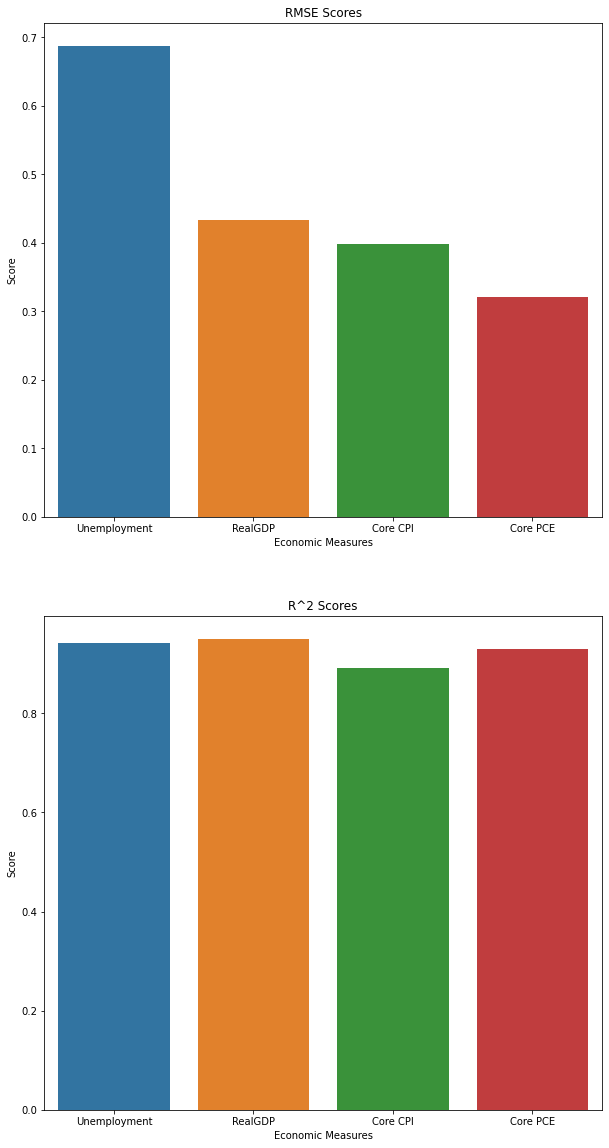

In [178]:
xgboost.plot_scores()

In [232]:
xg_scores = xgboost.create_results()

In [225]:
RF = RegressionModel("Random Forest" ,RandomForestRegressor())

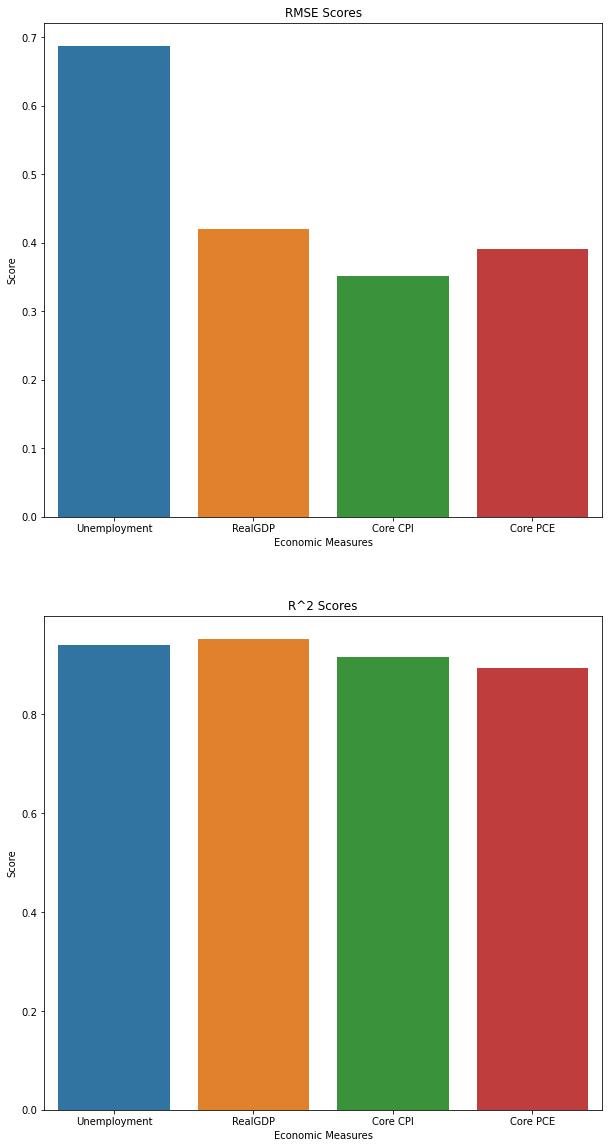

In [167]:
RF.plot_scores()

In [168]:
RF.get_predictions("Unemployment")

array([0.16216666, 3.87708362, 3.74769417, ..., 6.49433333, 3.79305557,
       6.30041667])

In [233]:
rf_scores = RF.create_results()

In [227]:
lm  = RegressionModel("Linear Regression", LinearRegression())

In [234]:
lm_scores = lm.create_results()

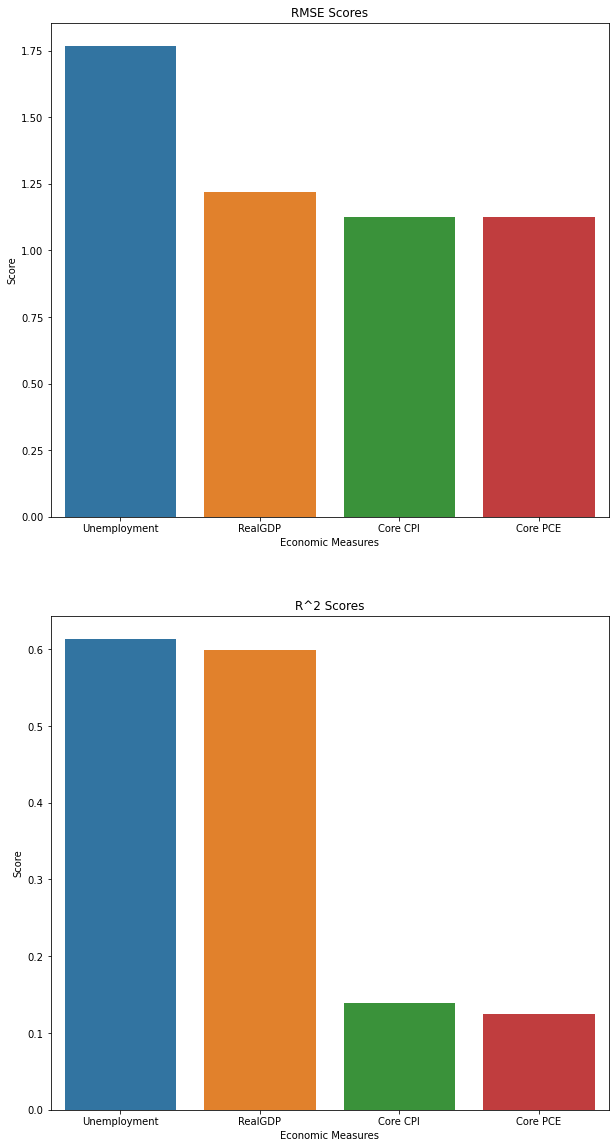

In [231]:
lm.plot_scores()

In [235]:
neighbors = RegressionModel("KNeigborsRegressor",KNeighborsRegressor())

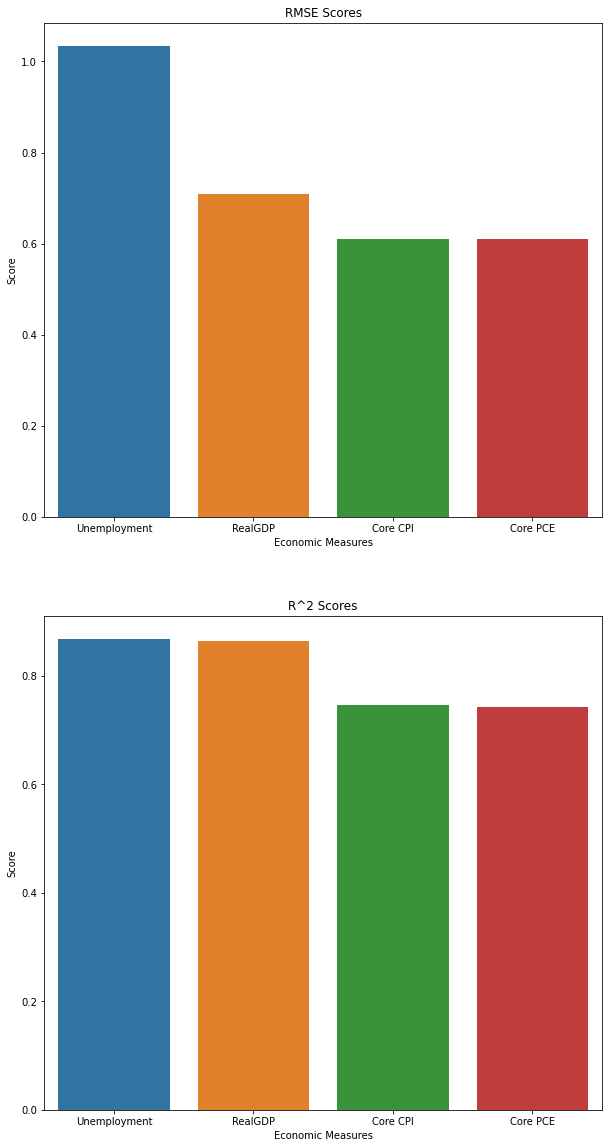

In [237]:
neighbors.plot_scores()

In [238]:
neighbor_scores = neighbors.create_results()

In [242]:
model_predictions = pd.concat([xg_scores,rf_scores,lm_scores,neighbor_scores],axis=1)

In [243]:
model_predictions

,XGBoost Unemployment,XGBoost RealGDP,XGBoost Core CPI,XGBoost Core PCE,Random Forest Unemployment,Random Forest RealGDP,Random Forest Core CPI,Random Forest Core PCE,Linear Regression Unemployment,Linear Regression RealGDP,Linear Regression Core CPI,Linear Regression Core PCE,KNeigborsRegressor Unemployment,KNeigborsRegressor RealGDP,KNeigborsRegressor Core CPI,KNeigborsRegressor Core PCE
0,0.081926,2.500126,2.291859,1.232153,0.081083,2.609857,2.279672,1.250697,2.763758,1.913119,2.037117,2.153685,1.621667,2.563892,2.270754,1.237391
1,3.820591,4.123776,2.132030,1.245136,3.866667,4.211068,2.174324,1.404765,4.956422,2.258982,1.673650,1.083818,3.850000,4.319114,2.174324,1.439257
2,3.852198,4.178174,2.079864,1.627884,3.716916,4.146253,1.940770,1.644099,3.938026,2.474587,1.802591,1.909056,3.808333,4.387366,1.562823,1.647664
3,8.142979,1.312183,2.193956,1.751450,8.108333,0.570160,2.223187,1.726642,4.816343,0.651697,2.003969,2.245712,6.338333,-1.492464,2.231115,1.727602
4,4.346418,4.914411,2.220703,1.585213,4.350000,4.559254,2.222196,1.718909,4.817755,4.013551,2.108200,2.264820,4.350000,4.377784,2.249111,1.975634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2665,NaN,2.994133,NaN,NaN,NaN,2.939068,NaN,NaN,NaN,4.166291,NaN,NaN,NaN,3.759920,NaN,NaN
2666,NaN,2.578147,NaN,NaN,NaN,2.686900,NaN,NaN,NaN,1.719996,NaN,NaN,NaN,2.108490,NaN,NaN
2667,NaN,4.376538,NaN,NaN,NaN,4.127480,NaN,NaN,NaN,3.387583,NaN,NaN,NaN,4.252632,NaN,NaN
2668,NaN,2.506146,NaN,NaN,NaN,2.401250,NaN,NaN,NaN,2.320658,NaN,NaN,NaN,2.375238,NaN,NaN


In [292]:
t = val.loc[:,["INDICATOR","actual"]]
initial = pd.DataFrame([])
for measure in xgboost.measures:
    temp = t[t["INDICATOR"]==measure]
    temp.rename(columns={"actual":measure + " actual"},inplace=True)
    temp.reset_index(inplace=True)
    initial = pd.concat([initial,temp],axis=1)
initial.drop(columns = ['index'],inplace=True)


C:\Users\Bear\anaconda3\lib\site-packages\pandas\core\frame.py:4438: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


MergeError: No common columns to perform merge on. Merge options: left_on=None, right_on=None, left_index=False, right_index=False

In [300]:
final = pd.concat([initial,model_predictions],axis=1)

In [301]:
final.to_csv("../models/results.csv",index=False)